# 🚀 S1W3D3 (Day 17): 编写训练循环

**今日目标**

1. **复习与整合**：将`SimpleCNN`和`DataLoader`引入同一个脚本。
2. **理解核心组件**：透彻理解**Loss Function(损失函数)**和**Optimizer (优化器)**的选择理由。
3. **掌握“五步法”**：熟练默写 PyTorch 训练循环的 5 个标准步骤。
4. **见证收敛**：亲眼看到 Loss 从高位下降，验证模型正在“学习”。

## 准备工作：环境与导入

In [5]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim

# --- 1. 关键步骤：挂载项目根目录 ---
# 解释：当前脚本在 stage1/week3/，我们需要向上跳两级找到 src 所在的根目录
project_root = os.path.abspath(os.path.join(os.getcwd(), "../..")) 
if project_root not in sys.path:
    sys.path.append(project_root)

# --- 2. 优雅导入 (从 src 包) ---
from src.utils import get_data_loaders  # 导入数据工具
from src.models import SimpleCNN        # 导入模型 (通过 __init__.py 暴露出来的)

print(f"✅ 项目根目录已挂载: {project_root}")
print("✅ src 模块导入成功！")

✅ 项目根目录已挂载: /home/goodminton/study/AI-Interview-Sprint
✅ src 模块导入成功！


## 核心知识点：损失函数与优化器

在开始循环之前，我们需要定义两个“教练”来指导模型学习。

### 损失函数 (Loss Function): `nn.CrossEntropyLoss`

- 为什么选它？ 它是多分类问题（如 0-9 数字分类）的标准答案。
- 它做了什么？ 它内部实际上组合了两个操作：LogSoftmax + NLLLoss (负对数似然损失)。
- 关键细节 (一定要懂)：
    - 它的输入是模型的`Logits`（即全连接层直接出来的原始数值，比如 [2.1, -0.5, ...]）。
    - 千万不要在模型 forward 的最后手动加 Softmax 层，否则就重复计算了，会导致梯度数值不稳定。

### 优化器（Optimizer）：`torch.optim.Adam`
- 为什么选它？
    - `SGD (随机梯度下降)`：最经典，但需要精细调节学习率 (Learning Rate)，容易陷入局部最优。
    - `Adam`：自带“自适应学习率”，它能根据梯度的变化自动调整步长。对于初学者和大多数任务来说，它是**无脑首选**，收敛速度快且稳。
- 参数`lr=0.001`：这是学习率。如果你发现 Loss 不下降，或者震荡很厉害，通常第一个要调的就是这个数。

In [6]:
# 1. 准备设备 (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 当前运行设备: {device}")

# 2. 加载数据
# 注意：data_root 指向根目录下的 data 文件夹
train_loader, test_loader = get_data_loaders(batch_size=64, data_root=os.path.join(project_root, 'data'))

# 3. 实例化模型
# ⚠️ 重点：SimpleCNN 是类，必须加 () 变成实例，然后搬到 GPU 上
model = SimpleCNN().to(device)

print("✅ 数据加载完毕，模型已就位。")

🚀 当前运行设备: cuda
✅ 数据加载完毕，模型已就位。


## 编写训练循环 (The Loop) - 核心中的核心

这是面试时必须能手写出来的代码片段。我们将训练 1 个 Epoch（把所有图片看一遍）。

代码逻辑如下：

1. **搬运**：把数据送到GPU/CPU。
2. **前向**：模型猜结果。
3. **算损**：看看猜的有多离谱。
4. **清零**：把上一轮的梯度忘掉。
5. **反向**：计算这一轮该怎么调参数（梯度）。
6. **更新**：根据梯度调整参数。

In [7]:
# 1. 损失函数（Loss Function）
# CrossEntropyLoss = LogSoftmax + NLLLoss
# 专门用于多分类，不需要手动加 Softmax
criterion = nn.CrossEntropyLoss()

# 2. 优化器 (Optimizer)
# Adam: 自适应学习率，初学者首选
# lr=0.001: 学习率 (Learning Rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 🔄 编写训练循环 (The Loop) - 核心中的核心

> 操作提示：运行以下代码。我们将训练 1 个 Epoch 来测试流程。

In [8]:
# 记录 Loss 用于画图
loss_history = []
total_step = len(train_loader)

print("------- 开始训练（Start Training）-------")

# 切换到训练模式（启用Dropout/BatchNorm等）
model.train()

for epoch in range(1):  # 这里我们只跑 1 个 Epoch 来测试流程
    for i, (images, labels) in enumerate(train_loader):

        # 1. 数据搬家（Data to Device）
        images= images.to(device)
        labels = labels.to(device)

        # --- 训练五步法 ---

        # 2. 前向传播 (Forward Pass)
        # 模型根据输入猜结果
        outputs = model(images)

        # 3. 计算损失 (Compute Loss)
        # 裁判打分：猜的有多错？
        loss = criterion(outputs, labels)

        # 4. 梯度清零（Zero Gradients）
        # 🧹 清除上一轮残留的梯度，否则会累加！
        optimizer.zero_grad()

        # 5. 反向传播 (Backward Pass)
        # 求导：计算每个参数对错误的贡献
        loss.backward()

        # 6. 优化参数 (Optimize Parameters)
        # 根据梯度调整参数：w = w - lr * grad
        optimizer.step()

        # 记录并打印损失
        loss_history.append(loss.item())

        # 每 100 个 batch 打印一次进度
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{1}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

print("------- 训练完成（Training Complete） -------")

------- 开始训练（Start Training）-------
Epoch [1/1], Step [100/938], Loss: 0.2687
Epoch [1/1], Step [200/938], Loss: 0.0916
Epoch [1/1], Step [300/938], Loss: 0.0499
Epoch [1/1], Step [400/938], Loss: 0.0294
Epoch [1/1], Step [500/938], Loss: 0.1002
Epoch [1/1], Step [600/938], Loss: 0.0412
Epoch [1/1], Step [700/938], Loss: 0.1211
Epoch [1/1], Step [800/938], Loss: 0.1167
Epoch [1/1], Step [900/938], Loss: 0.0340
------- 训练完成（Training Complete） -------


## 📈 验证结果：画出 Loss 曲线

如果一切正常，你应该看到 Loss 从最初的 `2.3` 左右（因为是 10 分类，瞎猜的概率是 0.1，-ln(0.1) ≈ 2.3）迅速下降到 `0.2` 甚至更低。

> **操作提示**：运行以下代码，直观感受“学习”的过程。

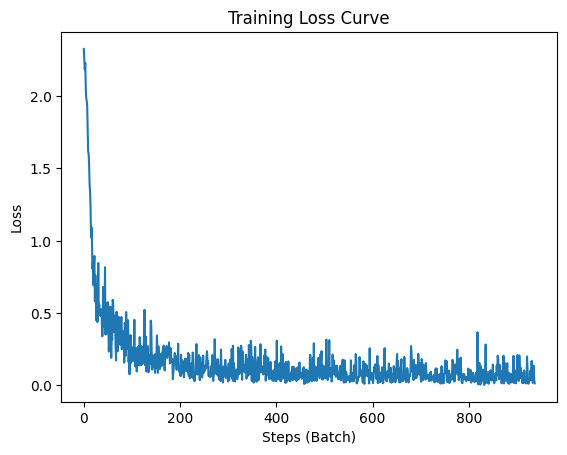

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Training Loss Curve')
plt.xlabel('Steps (Batch)')
plt.ylabel('Loss')
plt.show()

## 🛠️ 6. 封装与重构

为了让代码整洁，我们将上面的逻辑封装成一个函数 `train()`。这方便我们在后续几天多次调用。

> **操作提示**：将此代码添加到 Notebook，**或者**更新到你的 `utils.py` 中（如果更新到 utils，记得加 `import torch` 等头部引用，但为了简单，今天先放在 Notebook 里也可以）。

In [14]:
def train(model, device, train_loader, optimizer, epoch):
    """
    封装好的训练函数，只训练一个 Epoch
    """
    model.train() 
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx+1}/{len(train_loader)}] \tLoss: {loss.item():.6f}')

# 再跑一个 Epoch (Epoch 2)
train(model, device, train_loader, optimizer, epoch)

Train Epoch: 0 [200/938] 	Loss: 0.018072
Train Epoch: 0 [400/938] 	Loss: 0.007016
Train Epoch: 0 [600/938] 	Loss: 0.016390
Train Epoch: 0 [800/938] 	Loss: 0.020099


#### 📝 今日总结与思考

今天你成功编写了深度学习中最核心的 **Loop**。

请在心里复盘以下三个问题（能说清楚就是学会了）：

1.  **为什么 CrossEntropyLoss 不需要我在模型里加 Softmax？**
      * 答：因为它内部已经集成了 LogSoftmax，如果我加了就重复了，会出问题。
2.  **`optimizer.zero_grad()` 是干嘛的？如果不写会怎样？**
      * 答：它是清空上一轮积累的梯度。如果不写，梯度会累加，导致参数更新方向完全错误（步子迈得越来越大且方向不对），模型无法收敛。
3.  **`loss.item()` 有什么用？**
      * 答：`loss` 是一个 Tensor（张量），包含梯度信息。`item()` 取出里面的纯数值（Python float），如果不加 `item()` 直接累加，会把整个计算图都拖着，导致显存/内存瞬间爆炸。

## LeetCode练习题推荐

[LeetCode 566. 重塑矩阵 (Reshape the Matrix)](../../LeetCode%20practice/551-600.ipynb)

[LeetCode 661. 图片平滑器 (Image Smoother)](../../LeetCode%20practice/651-700.ipynb)

[LeetCode 867. 转置矩阵 (Transpose Matrix)](../../LeetCode%20practice/851-900.ipynb)